In [ ]:
!pip install d2l

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save"""Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
def download_extract(name, folder=None):  #@save"""Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save"""Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

# kaggle

## accesing reading datasets

In [ ]:
# import module

%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
# we can download and cache the Kaggle housing dataset using the script we defined above

DATA_HUB['kaggle_house_train'] = (  
DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
# load csv file

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [ ]:
# shape data

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## data prepocessing

In [ ]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(
    train_data.SalePrice.values.reshape(-1, 1), dtype=tf.float32)

## training

In [ ]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

In [ ]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

## K-fold crossValidation

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## model selection

fold 1, train log rmse 0.169571, valid log rmse 0.156654
fold 2, train log rmse 0.162406, valid log rmse 0.189546
fold 3, train log rmse 0.164033, valid log rmse 0.168286
fold 4, train log rmse 0.168235, valid log rmse 0.154563
fold 5, train log rmse 0.162243, valid log rmse 0.183291
5-fold validation: avg train log rmse: 0.165298, avg valid log rmse: 0.170468


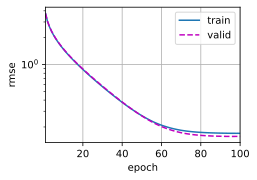

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')